<a href="https://colab.research.google.com/github/AssafR/ESU_202505_GitHub_101/blob/main/ESU_202505_smiley_mlp_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smiley Detector with a Fully Connected Neural Network (MLP)

In this notebook we will build a **tiny real-world-like project**:

> **Goal:** Detect whether a small image contains a smiley face or not.

We will:

1. **Define the problem in human terms** (a real-ish scenario).
2. **Generate a synthetic dataset** of tiny images (15×15 pixels) with and without a smiley.
3. **Visualize** several examples to build intuition.
4. Wrap the data in a proper **PyTorch `Dataset` and `DataLoader`** and understand what they do.
5. **Also** save the dataset to disk in an `ImageFolder`-style directory structure and load it with `torchvision.datasets.ImageFolder`.
6. Implement and train a **Multi-Layer Perceptron (MLP)** classifier.
7. Evaluate the model and discuss **what it can and cannot learn**.
8. Reflect on **why this setup naturally motivates Convolutional Neural Networks (CNNs)**.

This notebook is intentionally written in a **very readable, textbook-like style**, with:

- Clear separation between *ideas* (in Markdown) and *implementation* (in code).
- Utility functions that are small, well-documented, and easy to reuse.
- Math with LaTeX using `$ ... $` and `$$ ... $$` so it renders well in Colab.

We assume basic familiarity with:

- Python and NumPy
- Rudimentary PyTorch (tensors, `nn.Module`)
- Basic ideas of supervised learning and classification


In [1]:
import math
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (5, 5)

def set_seed(seed: int = 42) -> None:
    """Set random seeds for Python, NumPy, and PyTorch.

    This helps make runs more reproducible so that students
    see similar numbers and plots.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device configuration (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 1. Problem Setup: Detecting a Smiley in a Tiny Image

We will work with **tiny grayscale images** of size $15 \times 15$ pixels.

- Each pixel value is in the range $[0, 1]$.
- A sample is labeled:
  - `1` if a **smiley face** is present.
  - `0` if **no smiley** is present (just random shapes and noise).

Formally, each input image is a matrix
$$
X \in \mathbb{R}^{15 \times 15}
$$
which we will **flatten** into a vector
$$
\mathbf{x} \in \mathbb{R}^{225}
$$
before feeding it into a fully connected network.

Our model will then approximate a function
$$
f_\theta : \mathbb{R}^{225} \rightarrow \{0, 1\}
$$
parameterized by weights and biases $\theta$, and we will train it to minimize the **cross-entropy loss**.

Instead of downloading a dataset, we will **generate our own synthetic dataset** of smileys and non-smileys. This has several advantages:

- We control **difficulty** (amount of noise, variations).
- We can generate **as many samples as we want**.
- Students can clearly **see** what the model is trying to learn.


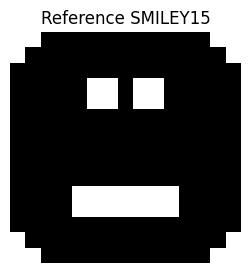

In [2]:
SMILEY15 = np.array([
[0,0,1,1,1,1,1,1,1,1,1,1,1,0,0],
[0,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,1,0,0,1,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,1,0,0,1,1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,0,0,0,0,0,0,0,1,1,1,1],
[1,1,1,1,0,0,0,0,0,0,0,1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
[0,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
[0,0,1,1,1,1,1,1,1,1,1,1,1,0,0],
], dtype=np.float32)


plt.figure(figsize=(3,3))
plt.imshow(SMILEY15, cmap='gray_r')
plt.title("Reference SMILEY15")
plt.axis('off')
plt.show()


In [3]:
SMILEY15 = 1 - SMILEY15


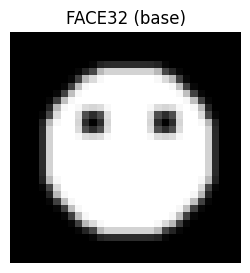

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from scipy.ndimage import gaussian_filter

# ---------------------------------------------------------
# Base 32×32 face without mouth (face + eyes only)
# ---------------------------------------------------------
def make_face32():
    img = np.zeros((32, 32), dtype=np.float32)

    # Face circle
    rr, cc = disk((16, 16), 12)
    img[rr, cc] = 1.0

    # Eyes
    rr, cc = disk((12, 11), 2)
    img[rr, cc] = 0.0
    rr, cc = disk((12, 21), 2)
    img[rr, cc] = 0.0

    img = gaussian_filter(img, sigma=0.6)
    return img

FACE32 = make_face32()

plt.figure(figsize=(3, 3))
plt.imshow(FACE32, cmap="gray")
plt.title("FACE32 (base)")
plt.axis("off")
plt.show()


# ---------------------------------------------------------
# Draw a classic smiley: base face + per-sample mouth
# ---------------------------------------------------------
def draw_smiley(size: int = 32,
                noise: float = 0.09, # 0.06,
                max_shift: int = 3) -> np.ndarray:
    """
    Generate a 32×32 'smiley' image:
    - Start from a fixed face (FACE32)
    - Add a slightly randomized smile (mouth)
    - Apply a small global shift
    - Add Gaussian noise
    """
    assert size == 32
    img = FACE32.copy()

    # --- Randomize smile a bit per sample ---
    # mouth_y0: where the smile sits vertically
    mouth_y0 = 22 + np.random.randint(-2, 3)   # 20..24
    # curvature: how "wide" the smile is
    # curvature = 0.03 + 0.02 * np.random.rand()  # ~0.03..0.05
    curvature = 0.03 + 0.01 * np.random.rand()  # ~0.03..0.05
    # x range: keep it inside the face, not touching edges
    # x_start, x_end = 6, 26
    x_start, x_end = 8, 24

    for x in range(x_start, x_end):
        xf = float(x)
        yf = -curvature * (xf - 16.0) ** 2 + mouth_y0
        y0 = int(np.floor(yf))
        y1 = y0 + 1
        t = yf - y0   # fractional part

        smile_color = 0.1 + 0.5 * np.random.rand()
        if 0 <= y0 < size:
            img[y0, x] = (1 - t) * smile_color + t * img[y0, x]
        if 0 <= y1 < size:
            img[y1, x] = t * smile_color + (1 - t) * img[y1, x]

    # --- Global shift (translation) ---
    if max_shift > 0:
        sx = np.random.randint(-max_shift, max_shift + 1)
        sy = np.random.randint(-max_shift, max_shift + 1)
        shifted = np.zeros_like(img)
        for y in range(size):
            for x in range(size):
                ny, nx = y + sy, x + sx
                if 0 <= ny < size and 0 <= nx < size:
                    shifted[ny, nx] = img[y, x]
        img = shifted

    # --- Noise ---
    img += np.random.normal(0, noise, img.shape)
    img = np.clip(img, 0.0, 1.0)

    return img


# ---------------------------------------------------------
# Non-smiley: noisy structured junk
# ---------------------------------------------------------
def draw_non_smiley(size: int = 32, noise: float = 0.10) -> np.ndarray:
    """
    Generate a 'non-smiley' image:
    - Either structured junk with lines/blobs
    - Or a 'fake face' that looks circle-like but is NOT a proper smiley.
    """

    img = 0.15 + np.random.rand(size, size) * 0.2   # base ~[0.15, 0.35]

    if np.random.rand() < 0.5:
        # --- Mode 1: junk with lines + blob (your current style) ---
        if np.random.rand() < 0.5:
            # soft bright blob
            cy, cx = np.random.randint(0, size, 2)
            rr = np.random.randint(4, 8)
            for y in range(size):
                for x in range(size):
                    if (y - cy) ** 2 + (x - cx) ** 2 <= rr ** 2:
                        img[y, x] = max(img[y, x], 0.8)

        number_of_lines_to_draw = 16
        for _ in range(number_of_lines_to_draw):
            x0, y0 = np.random.randint(0, size, 2)
            x1, y1 = np.random.randint(0, size, 2)
            L = max(abs(x1 - x0), abs(y1 - y0))
            for t in range(L + 1):
                x = int(x0 + (x1 - x0) * t / max(L, 1))
                y = int(y0 + (y1 - y0) * t / max(L, 1))
                if 0 <= x < size and 0 <= y < size:
                    img[y, x] = 1.0
    else:
        # --- Mode 2: a 'fake face' decoy ---
        # Circle roughly like FACE32, but with incorrect / missing features
        cy, cx = 16, 16
        radius = np.random.randint(10, 13)

        for y in range(size):
            for x in range(size):
                if (y - cy) ** 2 + (x - cx) ** 2 <= radius ** 2:
                    img[y, x] = max(img[y, x], 0.7)

        # Sometimes: only one eye, sometimes no eyes, sometimes 3...
        eye_modes = np.random.choice(["none", "one", "three"])
        if eye_modes != "none":
            eye_centers = [(12, 11), (12, 21), (12, 16)]
            np.random.shuffle(eye_centers)
            k = 1 if eye_modes == "one" else 3
            for (ey, ex) in eye_centers[:k]:
                for y in range(size):
                    for x in range(size):
                        if (y - ey) ** 2 + (x - ex) ** 2 <= 2**2:
                            img[y, x] = 0.0

        # Wrong mouth: too high, too flat, or inverted (sad)
        mouth_type = np.random.choice(["too_high", "too_flat", "frown"])
        mouth_y0 = 16 if mouth_type == "too_high" else 22
        curvature = 0.03 + 0.01 * np.random.rand()

        if mouth_type == "frown":
            sign = +1.0   # frown: curvature up
        else:
            sign = -curvature  # but in wrong vertical position / too flat

        x_start, x_end = 8, 24
        for x in range(x_start, x_end):
            xf = float(x)
            yf = sign * (xf - 16.0) ** 2 + mouth_y0
            y0 = int(np.floor(yf))
            y1 = y0 + 1
            t = yf - y0
            mouth_color = 0.3 + 0.4 * np.random.rand()
            if 0 <= y0 < size:
                img[y0, x] = img[y0, x] * 0.3 + mouth_color * 0.7
            if 0 <= y1 < size:
                img[y1, x] = img[y1, x] * 0.3 + mouth_color * 0.7

    # --- Add noise + clip ---
    img += np.random.normal(0, noise, img.shape)
    img = np.clip(img, 0.0, 1.0)
    return img



## 2. Visualizing the Synthetic Data

Before building a neural network, we should **look** at the data.

Questions to consider:

- Do smiley images look clearly different from non-smiley ones (to a human)?
- Are there obvious features (like bright circular patterns) that a model could exploit?
- Does the noise level make the task too easy or too hard?

We will now:

1. Generate a small batch of smiley and non-smiley images.
2. Display them in a grid using `matplotlib`.


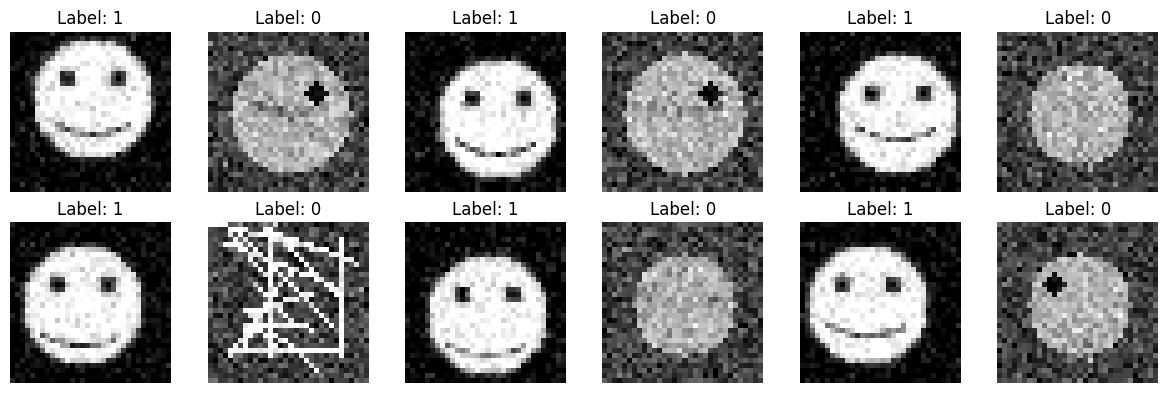

In [5]:
def show_mixed_examples(num_rows: int = 2, num_cols: int = 5, size: int = 15) -> None:
    """Display a grid of example images, alternating smiley and non-smiley.

    Args:
        num_rows: Number of rows in the grid.
        num_cols: Number of columns in the grid.
        size: Image size (height = width = size).
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    for r in range(num_rows):
        for c in range(num_cols):
            ax = axes[r, c] if num_rows > 1 else axes[c]
            if (r * num_cols + c) % 2 == 0:
                img = draw_smiley(size=size)
                label = 1
            else:
                img = draw_non_smiley(size=size)
                label = 0

            ax.imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
            ax.set_title(f"Label: {label}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

show_mixed_examples(num_rows=2, num_cols=6, size=32)


### A closer look: a grid of smiley faces only

To build more **visual intuition**, it helps to look at **many variations of the same class**.

Below we draw a grid of smiley faces only:

- Same basic structure (circle, eyes, smile).
- Slight differences due to noise.

You can discuss with students:

- What features stay the same across all smileys?
- What varies from one smiley to another?
- Which aspects do you think a neural network might latch onto?


In [6]:
# def show_smiley_grid(num_rows: int = 3, num_cols: int = 6, size: int = 15) -> None:
#     """Display a grid of smiley images only.

#     This helps visualize intra-class variation (how different smileys can still
#     be recognized as the same concept).
#     """
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

#     for r in range(num_rows):
#         for c in range(num_cols):
#             ax = axes[r, c] if num_rows > 1 else axes[c]
#             img = draw_smiley(size=size)
#             ax.imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
#             ax.set_xticks([])
#             ax.set_yticks([])

#     plt.suptitle("Different noisy versions of a 'smiley' face", fontsize=14)
#     plt.tight_layout()
#     plt.show()

# show_smiley_grid(num_rows=3, num_cols=6, size=32)


## 3. From Raw Arrays to PyTorch `Dataset` and `DataLoader`

Right now, we have **functions** that generate individual images.

To train a neural network in PyTorch, we usually want two abstractions:

1. **`Dataset`**  
   Represents a *collection* of samples. It knows how to return one sample `(x, y)` by index.  
   It implements:
   - `__len__(self)` – how many samples in total.
   - `__getitem__(self, idx)` – how to get the item at index `idx`.

2. **`DataLoader`**  
   Wraps a `Dataset` and provides:
   - **Batching**: groups samples into mini-batches of size `batch_size`.
   - **Shuffling**: changes the order of samples every epoch (if `shuffle=True`).
   - Optional parallel loading with multiple workers.

You can think of the training loop as:

```python
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        # use batch_x, batch_y to perform one optimization step
```

Where `train_loader` is a `DataLoader` that repeatedly asks its `Dataset` for samples
and hands them to us in nicely packaged batches:

```text
Dataset --> DataLoader --> (batch_x, batch_y) --> model
```

We will now:

- Implement a `SmileyDataset` which **pre-generates** a fixed number of samples in memory.
- Wrap it into `DataLoader` objects for **training** and **testing**.


In [7]:
def normalize_image(img):
  mean = img.mean()
  std = img.std()
  if std < 1e-6:
      std = 1e-6
  img_norm = (img - mean) / std

  return img_norm

In [8]:
class SmileyDataset(Dataset):
    """A PyTorch Dataset that holds synthetic 'smiley' classification data.

    Upon initialization, it generates a fixed set of images and labels.
    This makes the dataset deterministic across epochs and convenient
    for classroom use.
    """

    def __init__(
        self,
        n_samples: int = 2000,
        size: int = 32,
        noise: float = 0.06,
        p_smiley: float = 0.5,
        max_shift: int = 2,
    ):
        super().__init__()
        self.size = size

        images = []
        labels = []

        for _ in range(n_samples):
            if np.random.rand() < p_smiley:
                img = draw_smiley(size=size, noise=noise, max_shift=max_shift)
                label = 1
            else:
                img = draw_non_smiley(size=size, noise=noise)
                label = 0
            images.append(img.astype(np.float32))
            labels.append(label)

        self.images = np.stack(images, axis=0)          # (N, H, W)
        self.labels = np.array(labels, dtype=np.int64)  # (N,)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int):
        img = self.images[idx]    # (H, W)
        img = normalize_image(img) # NEW ADDITION ASSAF

        # add channel dimension for convs / consistency: (1, H, W)
        x = torch.from_numpy(img)[None, :, :]          # shape (1, 32, 32)

        label = self.labels[idx]
        y = torch.tensor(label, dtype=torch.long)

        return x, y

# Create train and test datasets in memory

train_dataset = SmileyDataset(
    n_samples=300, size=32, noise=0.06, p_smiley=0.5, max_shift=2
)
test_dataset = SmileyDataset(
    n_samples=2000, size=32, noise=0.06, p_smiley=0.5, max_shift=2
)

# hard_train_dataset = SmileyDataset(
#     n_samples=300, size=32, noise=0.09, p_smiley=0.5, max_shift=2
# )
# hard_test_dataset = SmileyDataset(
#     n_samples=2000, size=32, noise=0.12, p_smiley=0.5, max_shift=5
# )

# train_dataset = hard_train_dataset # TEMPORARY

# Wrap them in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)
# hard_test_loader = DataLoader(hard_test_dataset, batch_size=64, shuffle=False)

len(train_dataset), len(test_dataset)


(300, 2000)

In [9]:
# Sanity Check
# assuming train_dataset has .images and .labels
imgs = train_dataset.images  # (N, H, W)
labels = train_dataset.labels  # (N,)

smiley_mean = imgs[labels == 1].mean()
nonsmiley_mean = imgs[labels == 0].mean()

smiley_mean, nonsmiley_mean


(np.float32(0.40422097), np.float32(0.411911))

### 3.1 DataLoader 101: What actually happens in the training loop?

When we write:

```python
for batch_x, batch_y in train_loader:
    ...
```

PyTorch does the following under the hood:

1. Asks the `Dataset` for indices, for example `[0, 1, 2, ..., 63]` for a batch of 64.
2. Calls `__getitem__(idx)` for each of those indices to get `(x_i, y_i)`.
3. Stacks all `x_i` into a single tensor of shape `(batch_size, input_dim)`. E.g: One batch is a tensor of dimensions (64,225)
4. Stacks all `y_i` into a tensor of shape `(batch_size,)`.
5. Returns this pair `(batch_x, batch_y)` to the training loop.

If `shuffle=True`, the order of indices is randomized at the start of each epoch.
This is usually a very good idea because it prevents the model from **overfitting to the order** of the data.

We will now:

- Inspect the shapes and data types of a batch.
- Visualize a few images that come from a `DataLoader` batch.


batch_x shape: torch.Size([64, 1, 32, 32])
batch_y shape: torch.Size([64])
batch_x dtype: torch.float32
batch_y dtype: torch.int64


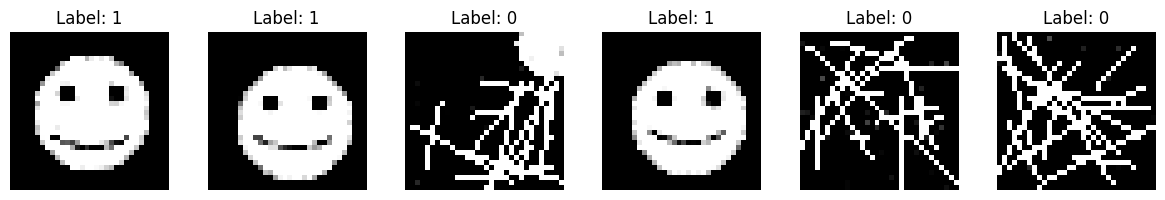

In [10]:
# Fetch one batch
batch_x, batch_y = next(iter(train_loader))

print("batch_x shape:", batch_x.shape)
print("batch_y shape:", batch_y.shape)
print("batch_x dtype:", batch_x.dtype)
print("batch_y dtype:", batch_y.dtype)

def show_batch_examples(batch_x: torch.Tensor, batch_y: torch.Tensor, n: int = 6) -> None:
    """
    Visualize up to n examples from a batch.
    Supports shapes:
    - (batch, H*W)
    - (batch, C, H, W)
    """
    import math

    # Determine image shape
    if batch_x.ndim == 2:
        # old style: (B, size*size)
        size = int(math.sqrt(batch_x.shape[1]))
        imgs = batch_x.view(-1, size, size).numpy()
    elif batch_x.ndim == 4:
        # new style: (B, C, H, W)
        _, C, H, W = batch_x.shape
        if C != 1:
            raise ValueError(f"Expected 1 channel, got {C}")
        imgs = batch_x[:, 0, :, :].numpy()   # strip channel dimension
        size = H
    else:
        raise ValueError(f"Unexpected batch_x shape: {batch_x.shape}")

    # Plot
    n = min(n, imgs.shape[0])
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    if n == 1:
        axes = [axes]

    for i in range(n):
        axes[i].imshow(imgs[i], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i].set_title(f"Label: {batch_y[i].item()}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()



show_batch_examples(batch_x, batch_y, n=6)


### 3.2 Mini-experiment: batch size and number of batches

A nice in-class discussion is:

- What happens if we change `batch_size`?
- How many iterations per epoch do we get for `batch_size = 1`, `32`, `64`, ...?

You can invite students to change the batch size in the DataLoader definition above and then run
the snippet below to see how many batches we get in one pass over the dataset.

The number of batches per epoch is roughly:
$$
{num\_batches} \approx \left\lceil \frac{N}{{batch\_size}} \right\rceil,
$$
where $N$ is the size of the dataset.


### Example:  If we have 1,000 samples, and a batch size of 64.
###    How many batches will we have?
Answer:     ceil(1000/64) = ceil(15.9) = 16


In [11]:
num_batches = len(train_loader)
print(f"Number of batches per epoch (train_loader): {num_batches}")

# Peek at the first 3 batch sizes
for i, (bx, by) in enumerate(train_loader):
    print(f"Batch {i}: x.shape={bx.shape}, y.shape={by.shape}")
    if i == 2:
        break


Number of batches per epoch (train_loader): 5
Batch 0: x.shape=torch.Size([64, 1, 32, 32]), y.shape=torch.Size([64])
Batch 1: x.shape=torch.Size([64, 1, 32, 32]), y.shape=torch.Size([64])
Batch 2: x.shape=torch.Size([64, 1, 32, 32]), y.shape=torch.Size([64])


### 3.3 Saving the synthetic dataset to disk (ImageFolder-style)

So far, our `SmileyDataset` keeps everything **in memory**.

In many real-world projects, datasets are stored as **image files on disk**, in a directory structure that encodes the labels.
A very common convention used by PyTorch is the **ImageFolder layout**:

```text
root/
    train/
        class_0_name/
            img001.png
            img002.png
            ...
        class_1_name/
            img003.png
            ...
    test/
        class_0_name/
        class_1_name/
```

We will now:

1. Generate a new synthetic smiley dataset.
2. Save it to disk under a directory like `smiley_dataset/` with subfolders:
   - `train/smiley/`
   - `train/nonsmiley/`
   - `test/smiley/`
   - `test/nonsmiley/`
3. Later, we will load it using `torchvision.datasets.ImageFolder`, which **automatically infers the labels from the directory names**.


In [12]:
# from PIL import Image

# def save_smiley_dataset(
#     root_dir: str = "smiley_dataset",
#     n_train: int = 2000,
#     n_test: int = 500,
#     size: int = 15,
#     noise: float = 0.10,
#     p_smiley: float = 0.5,
# ) -> None:
#     """Generate synthetic smiley/non-smiley images and save them to disk.

#     The directory structure is compatible with torchvision.datasets.ImageFolder:

#         root_dir/
#             train/
#                 smiley/
#                 nonsmiley/
#             test/
#                 smiley/
#                 nonsmiley/

#     Each image is saved as a tiny PNG (size x size, grayscale).
#     """
#     root = Path(root_dir)
#     train_smiley = root / "train" / "smiley"
#     train_non = root / "train" / "nonsmiley"
#     test_smiley = root / "test" / "smiley"
#     test_non = root / "test" / "nonsmiley"

#     # Create directories
#     for d in [train_smiley, train_non, test_smiley, test_non]:
#         d.mkdir(parents=True, exist_ok=True)

#     def save_split(num_samples: int, split_root: Path) -> None:
#         for i in range(num_samples):
#             is_smiley = (np.random.rand() < p_smiley)
#             if is_smiley:
#                 img = draw_smiley(size=size, noise=noise)
#                 out_dir = split_root / "smiley"
#                 fname = out_dir / f"smiley_{i:05d}.png"
#             else:
#                 img = draw_non_smiley(size=size, noise=noise)
#                 out_dir = split_root / "nonsmiley"
#                 fname = out_dir / f"nonsmiley_{i:05d}.png"

#             # Convert from [0,1] float32 to uint8 and save with PIL
#             img_uint8 = (img * 255).astype(np.uint8)
#             Image.fromarray(img_uint8).save(fname)

#     # Save train and test splits
#     save_split(n_train, root / "train")
#     save_split(n_test, root / "test")

#     print(f"Saved dataset to {root.resolve()}")


# # Actually generate and save a small on-disk dataset (you can re-run with larger sizes)
# save_smiley_dataset(root_dir="smiley_dataset", n_train=1000, n_test=300, size=32)

# !ls smiley_dataset/test/smiley/

### 3.4 Loading an on-disk dataset with `torchvision.datasets.ImageFolder`

Now that we have images on disk in the `ImageFolder` convention, we can let
`torchvision.datasets.ImageFolder` handle the heavy lifting:

- It scans the subdirectories under a given root.
- Each subdirectory name is treated as a **class name**.
- It assigns class indices in alphabetical order.
- It returns `(image_tensor, label)` pairs.

This demonstrates a very important idea:

> The **storage format** of the data (PNG files in folders) can be completely different,
> but the DataLoader always gives us the same abstraction: `(x, y)` batches.

We will:

1. Create `ImageFolder` datasets for `train/` and `test/`.
2. Wrap them in `DataLoader`s.
3. Inspect `class_to_idx` to see how labels were inferred.
4. Visualize a small batch from the on-disk dataset.


In [13]:
# from torchvision.datasets import ImageFolder
# from torchvision import transforms

# imagefolder_transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),  # ensure (1, H, W)
#     transforms.ToTensor(),                        # converts to float tensor in [0,1]
# ])

# train_folder_ds = ImageFolder(
#     root="smiley_dataset/train",
#     transform=imagefolder_transform,
# )

# test_folder_ds = ImageFolder(
#     root="smiley_dataset/test",
#     transform=imagefolder_transform,
# )

# print("Class-to-index mapping (from folder names):", train_folder_ds.class_to_idx)

# train_folder_loader = DataLoader(train_folder_ds, batch_size=32, shuffle=True)
# test_folder_loader  = DataLoader(test_folder_ds, batch_size=32, shuffle=False)


In [14]:
# loader = train_folder_loader
loader = train_loader


batch_imgs shape: torch.Size([64, 1, 32, 32])
batch_labels shape: torch.Size([64])


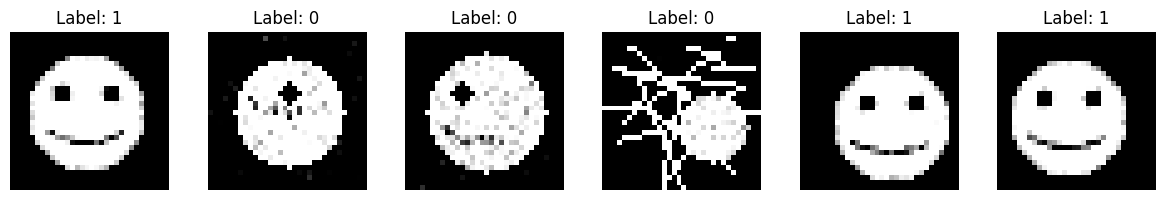

In [15]:
# Inspect one batch from the on-disk dataset
batch_imgs, batch_labels = next(iter(train_loader))
print("batch_imgs shape:", batch_imgs.shape)  # (B, 1, 15, 15)
print("batch_labels shape:", batch_labels.shape)

def show_imagefolder_batch(batch_imgs: torch.Tensor, batch_labels: torch.Tensor, n: int = 6) -> None:
    """Visualize a few examples loaded via ImageFolder.

    Args:
        batch_imgs: Tensor of shape (B, 1, H, W).
        batch_labels: Tensor of shape (B,).
        n: Number of examples to display.
    """
    n = min(n, batch_imgs.shape[0])
    _, _, H, W = batch_imgs.shape

    fig, axes = plt.subplots(1, n, figsize=(2 * n, 2))
    if n == 1:
        axes = [axes]

    for i in range(n):
        img = batch_imgs[i, 0].numpy()  # (H, W)
        label = batch_labels[i].item()
        axes[i].imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()



show_imagefolder_batch(batch_imgs, batch_labels, n=6)


> **Teaching tip:** At this point you can emphasize that whether we use
> `SmileyDataset` (synthetic in-memory) or `ImageFolder` (on-disk images),
> our **training loop does not change**. We always get `(batch_x, batch_y)`
> from a `DataLoader`. This is the power of the Dataset/DataLoader abstraction.


## 4. Defining a Fully Connected Neural Network (MLP)

We will now define a **Multi-Layer Perceptron (MLP)** to classify our images.

Recall:

- Each input image is flattened to a vector $\mathbf{x} \in \mathbb{R}^{225}$.
- We want to produce **class scores** for 2 classes (no smiley, smiley).

We will use a simple architecture:

- Input layer: size $225$
- Hidden layer 1: size $64$, followed by ReLU
- Hidden layer 2: size $32$, followed by ReLU
- Output layer: size $2$ (logits for the two classes)

Formally, if we denote:

- $\mathbf{x} \in \mathbb{R}^{225}$ the input vector,
- $\sigma(\cdot)$ the ReLU activation function,

then the network computes:
$$
\begin{aligned}
\mathbf{h}_1 &= \sigma(W_1 \mathbf{x} + \mathbf{b}_1) \\
\mathbf{h}_2 &= \sigma(W_2 \mathbf{h}_1 + \mathbf{b}_2) \\
\mathbf{z}   &= W_3 \mathbf{h}_2 + \mathbf{b}_3
\end{aligned}
$$
where $\mathbf{z} \in \mathbb{R}^2$ are the **logits** (unnormalized scores) for the two classes.

We will combine this with **cross-entropy loss**, which internally applies `softmax` to $\mathbf{z}$.


In [16]:
# class SmileyMLP(nn.Module):
#     """A simple fully connected neural network (MLP) for binary classification
#     of flattened 15x15 images.

#     Architecture:
#         Input (225) -> Linear(225, 64) -> ReLU
#                      -> Linear(64, 32) -> ReLU
#                      -> Linear(32, 2)  (logits for 2 classes)
#     """

#     def __init__(self, input_dim: int = 15 * 15, hidden1: int = 64, hidden2: int = 32, num_classes: int = 2) -> None:
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Linear(input_dim, hidden1),
#             nn.ReLU(),
#             nn.Linear(hidden1, hidden2),
#             nn.ReLU(),
#             nn.Linear(hidden2, num_classes),
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         """Forward pass through the network.

#         Args:
#             x: Tensor of shape (batch_size, input_dim).

#         Returns:
#             logits: Tensor of shape (batch_size, num_classes).
#         """
#         return self.net(x)


# model = SmileyMLP().to(device)
# print(model)


In [17]:
import torch.nn as nn

# class SmallMLP(nn.Module):
#     def __init__(self, in_dim: int = 32 * 32, hidden: int = 6):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_dim, hidden),
#             nn.ReLU(),
#             nn.Linear(hidden, 3),
#             nn.ReLU(),
#             nn.Linear(3, 2),
#         )

#     def forward(self, x):
#         return self.net(x)

# model = SmallMLP().to(device)
# print(model)


class TinyMLP(nn.Module):
    def __init__(self, in_dim: int = 32 * 32, hidden: int = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, hidden),
            nn.Tanh(),          # smoother, less aggressive than ReLU
            nn.Linear(hidden, 2)
        )

    def forward(self, x):
        return self.net(x)

model = TinyMLP().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()

# Slower, more classical optimizer with regularization
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,          # a bit larger to avoid getting completely stuck
    momentum=0.0,
    weight_decay=5e-3 # stronger L2: discourages memorization
)




TinyMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=4, bias=True)
    (2): Tanh()
    (3): Linear(in_features=4, out_features=2, bias=True)
  )
)


In [18]:
# Count the number of learnable parameters in model:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {num_params}")

Number of learnable parameters: 4110


## 5. Training Objective and Optimization

We now need:

1. A **loss function** that measures how wrong the model's predictions are.
2. An **optimizer** that updates the model parameters using gradients.

For classification with logits, the standard choice in PyTorch is:

- `nn.CrossEntropyLoss()`  

This combines:

- `nn.LogSoftmax()` on the logits
- and `nn.NLLLoss()` on the log-probabilities,

into one numerically stable operation.

We will use:

- Loss: **Cross-Entropy**
- Optimizer: **Adam** with a small learning rate, e.g. `1e-3`

We will also write small utility functions:

- `train_one_epoch(...)` – one pass over the training data.
- `evaluate(...)` – compute loss and accuracy on a given loader.
- A simple training loop that records metrics for later plotting.


In [19]:
def accuracy_from_logits(logits: torch.Tensor, labels: torch.Tensor) -> float:
    """Compute classification accuracy given logits and ground-truth labels.

    Args:
        logits: Tensor of shape (batch_size, num_classes).
        labels: Tensor of shape (batch_size,) with integer class indices.

    Returns:
        Accuracy as a Python float (between 0 and 1).
    """
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total


def train_one_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device,
) -> tuple[float, float]:
    """Train the model for a single epoch.

    Args:
        model: The neural network to train.
        data_loader: DataLoader providing (inputs, labels) for training.
        optimizer: Optimizer (e.g. Adam, SGD).
        loss_fn: Loss function (e.g. CrossEntropyLoss).
        device: CPU or GPU device.

    Returns:
        Tuple (avg_loss, avg_accuracy) over the epoch.
    """
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    num_batches = 0

    for batch_x, batch_y in data_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        logits = model(batch_x)
        loss = loss_fn(logits, batch_y)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        acc = accuracy_from_logits(logits, batch_y)
        running_loss += loss.item()
        running_acc += acc
        num_batches += 1

    avg_loss = running_loss / num_batches
    avg_acc = running_acc / num_batches
    return avg_loss, avg_acc


def evaluate(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    device: torch.device,
) -> tuple[float, float]:
    """Evaluate the model on a validation or test set.

    Args:
        model: The neural network to evaluate.
        data_loader: DataLoader providing (inputs, labels).
        loss_fn: Loss function (e.g. CrossEntropyLoss).
        device: CPU or GPU device.

    Returns:
        Tuple (avg_loss, avg_accuracy) over the entire loader.
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    num_batches = 0

    # We don't need gradients for evaluation
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            loss = loss_fn(logits, batch_y)
            acc = accuracy_from_logits(logits, batch_y)

            running_loss += loss.item()
            running_acc += acc
            num_batches += 1

    avg_loss = running_loss / num_batches
    avg_acc = running_acc / num_batches
    return avg_loss, avg_acc


## 6. Training the MLP on the Smiley Dataset

We are now ready to train on our **in-memory** `SmileyDataset`:

- Initialize the model (already done above).
- Define:
  - `loss_fn = nn.CrossEntropyLoss()`
  - `optimizer = optim.Adam(model.parameters(), lr=1e-3)`
- Loop over a small number of epochs (e.g. 10–20).
- After each epoch:
  - Compute training loss and accuracy.
  - Compute test loss and accuracy.
  - Store metrics for plotting.

While training runs, pay attention to:

- Does the **training loss** decrease?
- Does the **test accuracy** improve?
- Are we overfitting (train much better than test)?

We will also plot the **learning curves** (loss and accuracy over epochs).

> **Exercise idea:** After you run this once, try swapping `train_loader` / `test_loader`
> with `train_folder_loader` / `test_folder_loader` from the ImageFolder section
> (but remember to flatten the images or adapt the model accordingly).


TinyMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=4, bias=True)
    (2): Tanh()
    (3): Linear(in_features=4, out_features=2, bias=True)
  )
)
Epoch 01 | train_loss=0.6317, train_acc=0.701 | test_loss=0.6053, test_acc=0.800
Epoch 02 | train_loss=0.5793, train_acc=0.829 | test_loss=0.5894, test_acc=0.792
Epoch 03 | train_loss=0.5618, train_acc=0.836 | test_loss=0.5711, test_acc=0.833
Epoch 04 | train_loss=0.5440, train_acc=0.880 | test_loss=0.5570, test_acc=0.839
Epoch 05 | train_loss=0.5231, train_acc=0.913 | test_loss=0.5494, test_acc=0.805
Epoch 06 | train_loss=0.5104, train_acc=0.892 | test_loss=0.5317, test_acc=0.852
Epoch 07 | train_loss=0.4910, train_acc=0.914 | test_loss=0.5192, test_acc=0.861
Epoch 08 | train_loss=0.4749, train_acc=0.919 | test_loss=0.5106, test_acc=0.848
Epoch 09 | train_loss=0.4614, train_acc=0.924 | test_loss=0.5014, test_acc=0.844
Epoch 10 | train_loss=0.4458, train_acc=0.925 | test_loss=

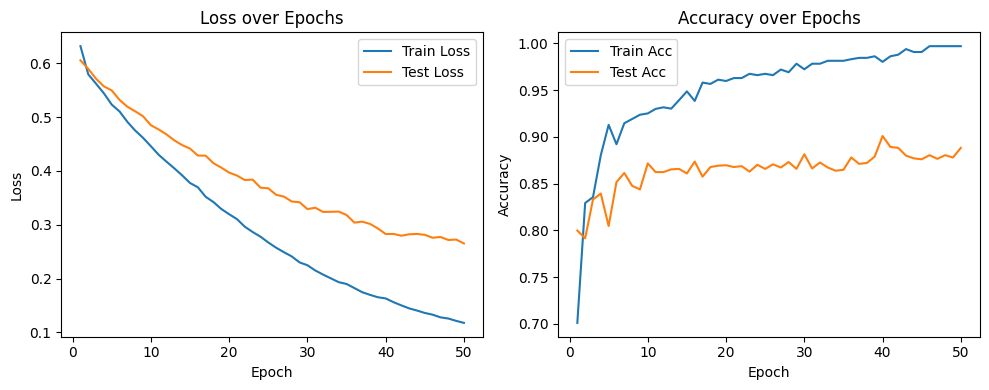

In [20]:
# Re-initialize model (in case you re-run this cell)
# model = SmileyMLP().to(device)
# model = SmallMLP().to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(model)
num_epochs = 50 #15

history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    # test_loss, test_acc = evaluate(model, hard_test_loader, loss_fn, device)


    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(
        f"Epoch {epoch:02d} "
        f"| train_loss={train_loss:.4f}, train_acc={train_acc:.3f} "
        f"| test_loss={test_loss:.4f}, test_acc={test_acc:.3f}"
    )

# Plot loss and accuracy curves
epochs = range(1, num_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(epochs, history["train_loss"], label="Train Loss")
axes[0].plot(epochs, history["test_loss"], label="Test Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss over Epochs")
axes[0].legend()

axes[1].plot(epochs, history["train_acc"], label="Train Acc")
axes[1].plot(epochs, history["test_acc"], label="Test Acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy over Epochs")
axes[1].legend()

plt.tight_layout()
plt.show()


## 7. Looking at Predictions: Where Does the Model Succeed or Fail?

Numbers are important, but for building **intuition**, it is extremely helpful
to look at actual **examples** together with their predicted labels.

We will:

1. Take a batch from the test set.
2. Compute model predictions.
3. Display a grid with:
   - The image
   - The **true label** (0 = no smiley, 1 = smiley)
   - The **predicted label**

You can invite students to:

- Find misclassified examples.
- Hypothesize *why* the model got them wrong (noise, shape ambiguity, etc.).


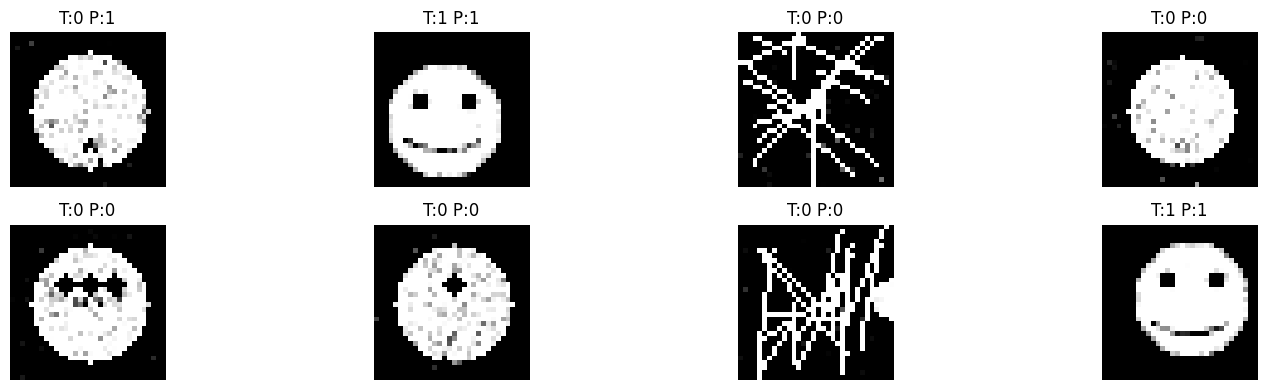

In [21]:
def show_predictions(
    model: nn.Module,
    data_loader: DataLoader,
    device: torch.device,
    n: int = 8,
) -> None:
    """Display n samples from the given data_loader with model predictions."""

    model.eval()

    # Collect enough samples from the loader
    xs, ys, ps = [], [], []
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            batch_preds = logits.argmax(dim=1)

            xs.append(batch_x.cpu())
            ys.append(batch_y.cpu())
            ps.append(batch_preds.cpu())

            if sum(len(t) for t in ys) >= n:
                break

    X = torch.cat(xs, dim=0)[:n]      # (n, 1, H, W)
    Y = torch.cat(ys, dim=0)[:n]
    P = torch.cat(ps, dim=0)[:n]

    size = X.shape[-1]

    fig, axes = plt.subplots(2, n // 2, figsize=(2 * n, 4))
    axes = axes.ravel()

    for i in range(n):
        img = X[i, 0].numpy()
        true_label = int(Y[i].item())
        pred_label = int(P[i].item())

        axes[i].imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
        axes[i].set_title(f"T:{true_label} P:{pred_label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Example usage:
show_predictions(model, test_loader, device, n=8)


## 8. Reflection: What Did We Learn? (And Why This Leads to CNNs)

In this notebook we:

1. **Defined a simple but meaningful task**  
   Detect if a tiny image contains a smiley face.

2. **Generated synthetic data**  
   - Smiley vs non-smiley images with noise.
   - Built a proper `Dataset` and `DataLoader` (in-memory).
   - Also saved the dataset as PNG files and loaded it with `ImageFolder`.

3. **Trained a fully connected network (MLP)**  
   - Input dimension: $225$ (flattened $15 \times 15$ image).
   - Two hidden layers with ReLU activations.
   - Cross-entropy loss, trained with Adam.

4. **Evaluated and visualized results**  
   - Learning curves (loss and accuracy).
   - Individual predictions on the test set.

---

### Where MLPs Work Well

On this tiny artificial problem, a well-chosen MLP can reach **reasonable accuracy**.  
It learns to pick up patterns like:

- The circular outline of the face.
- Regular placement of eyes.
- The curved smile.

---

### Where MLPs Start to Break

However, if we slightly **change the data**, problems appear:

- Shift the smiley up/down/left/right by a few pixels.
- Rotate the smiley a bit.
- Change the scale of the face.

Then the MLP tends to **fail dramatically**, because:

- It treats every pixel position as an independent input feature.
- It cannot easily re-use the same pattern (like an eye) at different positions.
- It has no built-in notion of **locality** or **translation invariance**.

In other words, the MLP is *memorizing* where features appear, rather than *what* they look like.

---

### This Motivates Convolutional Neural Networks (CNNs)

Convolutional layers were invented to solve exactly this kind of problem:

- Use **shared filters** that slide over the image.
- Detect patterns (edges, corners, eyes, etc.) **regardless of their position**.
- Build richer, hierarchical representations with significantly fewer parameters.

In the next lesson, we can:

- Take the **same smiley dataset** (possibly with more translations and variations).
- Show that the MLP struggles.
- Introduce a small **CNN** (with convolution + pooling).
- Demonstrate how CNNs handle shifts and local patterns much more gracefully.

This creates a very natural story arc:

> "We tried a fully connected network, saw both its power and its limitations,  
> and now we have a real reason to invent a new architecture."
